In [1]:
from time import time
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
from batchgenerators.dataloading import MultiThreadedAugmenter
from batchgenerators.examples.brats2017.config import brats_preprocessed_folder, num_threads_for_brats_example
from batchgenerators.transforms import Compose
from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.utilities.file_and_folder_operations import *
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform

In [2]:
def get_list_of_patients(preprocessed_data_folder):
    npy_files = subfiles(preprocessed_data_folder, suffix=".npy", join=True)
    # remove npy file extension
    patients = [i[:-4] for i in npy_files]
    return patients

In [64]:
?? pad_nd_image

In [3]:
class BraTS2017DataLoader3D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, seed_for_shuffle=1234,
                 return_incomplete=False, shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        self.patch_size = patch_size
        self.num_modalities = 4
        self.indices = list(range(len(data)))

    @staticmethod
    def load_patient(patient):
        data = np.load(patient + ".npy", mmap_mode="r")
        metadata = load_pickle(patient + ".pkl")
        return data, metadata

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data[i] for i in idx]

        # initialize empty array for data and seg
        data = np.zeros((self.batch_size, self.num_modalities, *self.patch_size), dtype=np.float32)
        seg = np.zeros((self.batch_size, 1, *self.patch_size), dtype=np.float32)

        metadata = []
        patient_names = []

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data, patient_metadata = self.load_patient(j)

            # this will only pad patient_data if its shape is smaller than self.patch_size
            patient_data = pad_nd_image(patient_data, self.patch_size)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            patient_data, patient_seg = crop(patient_data[:-1][None], patient_data[-1:][None], self.patch_size, crop_type="random")

            data[i] = patient_data[0]
            seg[i] = patient_seg[0]

            metadata.append(patient_metadata)
            patient_names.append(j)

        return {'data': data, 'seg':seg, 'metadata':metadata, 'names':patient_names}

In [4]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform_2(
            patch_size, [i // 2 for i in patch_size],
            do_elastic_deform=True, deformation_scale=(0, 0.25),
            do_rotation=True,
            angle_x=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_y=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_z=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            do_scale=True, scale=(0.75, 1.25),
            border_mode_data='constant', border_cval_data=0,
            border_mode_seg='constant', border_cval_seg=0,
            order_seg=1, order_data=3,
            random_crop=True,
            p_el_per_sample=0.1, p_rot_per_sample=0.1, p_scale_per_sample=0.1
        )
    )

    # now we mirror along all axes
    tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

    # gamma transform. This is a nonlinear transformation of intensity values
    # (https://en.wikipedia.org/wiki/Gamma_correction)
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=0.15))
    # we can also invert the image, apply the transform and then invert back
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=0.15))

    # Gaussian Noise
    tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

    # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
    # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
                                               p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

In [5]:
brats_preprocessed_folder = 'brats_data_preprocessed/Brats17TrainingData'

In [6]:
patients = get_list_of_patients(brats_preprocessed_folder)

In [7]:
patients

['brats_data_preprocessed/Brats17TrainingData/Brats17_2013_0_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_10_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_11_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_12_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_13_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_14_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_15_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_16_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_17_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_18_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_19_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_1_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_20_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_21_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_2013_22_1',
 'brats_data

In [8]:
# num_splits=5 means 1/5th is validation data!
train, val = get_split_deterministic(patients, fold=0, num_splits=5, random_state=12345)

In [9]:
len(train)

228

In [10]:
len(val)

57

In [11]:
patch_size = (128, 128, 128)
batch_size = 2

In [12]:
dataloader = BraTS2017DataLoader3D(train, batch_size, patch_size, 1)

In [13]:
batch = next(dataloader)

In [14]:
batch.keys()

dict_keys(['data', 'seg', 'metadata', 'names'])

In [15]:
batch['data'].shape

(2, 4, 128, 128, 128)

In [16]:
import matplotlib.pyplot as plt

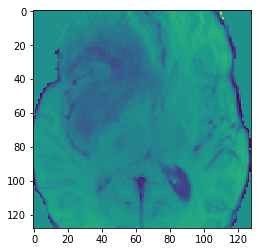

In [42]:
plt.imshow(batch['data'][1,0,70,:,:])

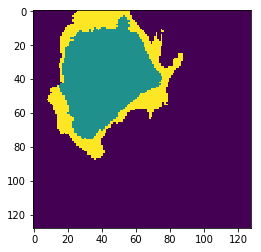

In [43]:
plt.imshow(batch['seg'][1,0,70,:,:])

In [44]:
batch['metadata']

[{'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  6, 142],
         [ 43, 215],
         [ 50, 187]])},
 {'spacing': array([1., 1., 1.]),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (-0.0, -239.0, 0.0),
  'original_shape': (155, 240, 240),
  'nonzero_region': array([[  0, 143],
         [ 39, 218],
         [ 52, 184]])}]

In [45]:
batch['names']

['brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_474_1',
 'brats_data_preprocessed/Brats17TrainingData/Brats17_TCIA_625_1']

## Data Augmentation

In [46]:
# first let's collect all shapes, you will see why later
shapes = [BraTS2017DataLoader3D.load_patient(i)[0].shape[1:] for i in patients]
max_shape = np.max(shapes, 0)
max_shape = np.max((max_shape, patch_size), 0)

In [47]:
shapes

[(133, 159, 133),
 (132, 176, 136),
 (143, 165, 143),
 (130, 169, 128),
 (140, 170, 147),
 (135, 174, 141),
 (131, 167, 131),
 (135, 176, 145),
 (144, 183, 145),
 (140, 177, 146),
 (138, 169, 141),
 (132, 175, 146),
 (146, 175, 146),
 (130, 156, 129),
 (139, 164, 157),
 (137, 177, 139),
 (130, 165, 141),
 (136, 171, 144),
 (128, 180, 141),
 (142, 166, 149),
 (133, 161, 149),
 (138, 163, 137),
 (129, 179, 142),
 (137, 155, 144),
 (135, 169, 144),
 (146, 176, 142),
 (133, 167, 144),
 (132, 159, 137),
 (140, 168, 151),
 (145, 171, 131),
 (135, 173, 137),
 (140, 187, 134),
 (135, 163, 129),
 (140, 182, 135),
 (140, 175, 133),
 (141, 177, 133),
 (138, 170, 139),
 (138, 179, 140),
 (144, 170, 130),
 (141, 171, 130),
 (142, 160, 152),
 (143, 178, 138),
 (140, 164, 145),
 (143, 179, 141),
 (141, 176, 144),
 (140, 176, 133),
 (141, 177, 140),
 (136, 167, 137),
 (137, 167, 133),
 (139, 180, 140),
 (136, 157, 133),
 (143, 187, 132),
 (147, 168, 127),
 (144, 170, 138),
 (139, 160, 131),
 (142, 184

In [48]:
max_shape

array([149, 189, 157])

In [49]:
dataloader_train = BraTS2017DataLoader3D(train, batch_size, max_shape, 1)

In [50]:
dataloader_validation = BraTS2017DataLoader3D(val, batch_size, patch_size, 1)

In [51]:
tr_transforms = get_train_transform(patch_size)

In [52]:
tr_transforms

Compose ( [SpatialTransform_2( p_rot_per_sample = 0.1, p_scale_per_sample = 0.1, p_el_per_sample = 0.1, data_key = 'data', label_key = 'seg', patch_size = (128, 128, 128), patch_center_dist_from_border = [64, 64, 64], do_elastic_deform = True, deformation_scale = (0, 0.25), do_rotation = True, angle_x = (-0.2617993877991494, 0.2617993877991494), angle_y = (-0.2617993877991494, 0.2617993877991494), angle_z = (-0.2617993877991494, 0.2617993877991494), do_scale = True, scale = (0.75, 1.25), border_mode_data = 'constant', border_cval_data = 0, order_data = 3, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 1, random_crop = True ), MirrorTransform( data_key = 'data', label_key = 'seg', axes = (0, 1, 2) ), BrightnessMultiplicativeTransform( p_per_sample = 0.15, data_key = 'data', multiplier_range = (0.7, 1.5), per_channel = True ), GammaTransform( p_per_sample = 0.15, retain_stats = False, per_channel = True, data_key = 'data', gamma_range = (0.5, 2), invert_image = False ), G

In [53]:
# finally we can create multithreaded transforms that we can actually use for training
# we don't pin memory here because this is pytorch specific.
tr_gen = MultiThreadedAugmenter(dataloader_train, tr_transforms, num_processes=num_threads_for_brats_example,
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)
# we need less processes for vlaidation because we dont apply transformations
val_gen = MultiThreadedAugmenter(dataloader_validation, None,
                                 num_processes=max(1, num_threads_for_brats_example // 2), num_cached_per_queue=1,
                                 seeds=None,
                                 pin_memory=False)

In [54]:
# lets start the MultiThreadedAugmenter. This is not necessary but allows them to start generating training
# batches while other things run in the main thread
tr_gen.restart()
val_gen.restart()

In [55]:
# now if this was a network training you would run epochs like this (remember tr_gen and val_gen generate
# inifinite examples! Don't do "for batch in tr_gen:"!!!):
num_batches_per_epoch = 10
num_validation_batches_per_epoch = 3
num_epochs = 5
# let's run this to get a time on how long it takes
time_per_epoch = []
start = time()
for epoch in range(num_epochs):
    start_epoch = time()
    for b in range(num_batches_per_epoch):
        batch = next(tr_gen)
        # do network training here with this batch

    for b in range(num_validation_batches_per_epoch):
        batch = next(val_gen)
        # run validation here
    end_epoch = time()
    time_per_epoch.append(end_epoch - start_epoch)
end = time()
total_time = end - start
print("Running %d epochs took a total of %.2f seconds with time per epoch being %s" %
      (num_epochs, total_time, str(time_per_epoch)))

Running 5 epochs took a total of 86.12 seconds with time per epoch being [4.915756464004517, 14.611761569976807, 30.529673099517822, 21.851526498794556, 14.206583023071289]


## Visualize augmented example

In [56]:
batch = next(tr_gen)

In [58]:
batch['data'].shape

(2, 4, 128, 128, 128)

In [59]:
augmented = np.concatenate((batch['data'][0], batch['seg'][0]), 0)[:, None]

In [60]:
augmented.shape

(5, 1, 128, 128, 128)

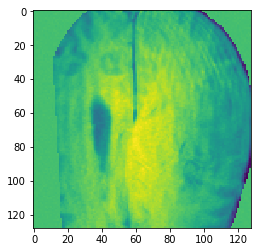

In [63]:
plt.imshow(augmented[0, 0, 80])